In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
from keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM, CuDNNLSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from tqdm import tqdm

Using TensorFlow backend.


In [3]:
lemmatizer = WordNetLemmatizer()

In [4]:
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')

train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
train.shape

(156060, 4)

In [6]:
test.shape

(66292, 3)

In [7]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [8]:
def clean_sentences(df):
    reviews = []
    
    for sent in tqdm(df['Phrase']):
        
        # removing html content if any
        review_text = BeautifulSoup(sent).get_text()
        
        # removing non alphabetic characters
        review_text = re.sub("[^A-Za-z]", " ", review_text)
        
        # tokenizing the sentences
        words = word_tokenize(review_text.lower())
        
        # lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        
        reviews.append(lemma_words)
        
    return reviews

In [9]:
# clean reviews for both train and test set
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)

print(len(train_sentences))
print(len(test_sentences))

100%|██████████| 66292/66292 [00:28<00:00, 2328.31it/s]

156060
66292


In [10]:
target = train.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    train_sentences, y_target, test_size=0.2, stratify=y_target)

In [12]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if len(sent) > len_max:
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 643268.10it/s]

13737
48


In [13]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

In [14]:
# padding the the sentences with smaller length than max_length
# lstm needs sentences with equal sizes
# will be padded with zeros in the end

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)
print(X_train.shape, X_val.shape, X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [17]:
model = Sequential()

model.add(Embedding(len(list(unique_words)), 500, input_length=len_max))

model.add(CuDNNLSTM(128, return_sequences=True))
model.add(CuDNNLSTM(64, return_sequences=False))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=0.001, decay=1e-6))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 500)           6867000   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 48, 128)           322560    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 64)                49664     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 7,248,189
Trainable params: 7,248,189
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/5
124848/124848 [==============================] - 590s 5ms/step - loss: 0.9359 - val_loss: 0.8103
Epoch 2/5
124848/124848 [==============================] - 633s 5ms/step - loss: 0.7443 - val_loss: 0.7769
Epoch 3/5
124848/124848 [==============================] - 655s 5ms/step - loss: 0.6637 - val_loss: 0.7821
Epoch 4/5
124848/124848 [==============================] - 526s 4ms/step - loss: 0.6023 - val_loss: 0.8148
Epoch 5/5
124848/124848 [==============================] - 602s 5ms/step - loss: 0.5473 - val_loss: 0.8960


In [19]:
import matplotlib.pyplot as plt

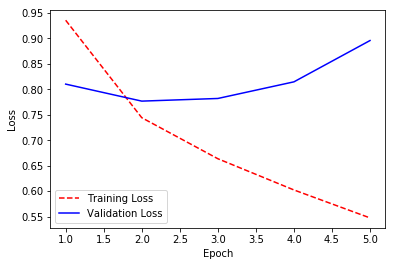

In [22]:
# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()